In [9]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
from functools import reduce
import seaborn as sns
from typing import List

# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [10]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler,Bucketizer
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct, expr
from pyspark.sql.types import *

MAX_MEMORY = '8G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Lab_1_SOBD") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

#Инициализация объекта SparkSession
spark = init_spark()

#Определение пути к каталогу, где находится файл
directory_path = "data/"
selected_file = 'itineraries.csv'

# Чтение выбранного файла и создание DataFrame
#                                              header - содержание в первой строке заголовков столбцов
#                                              inferSchema - автоматическое определение типов
#                                              sep - разделитель
dataframe = spark.read.csv(os.path.join(directory_path, selected_file), header=True, inferSchema=True, sep=',')

# Преобразование в Pandas Dataframe и вывод первых строк 
dataframe.limit(5).toPandas().head()

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,9ca0e81111c683bec1012473feefd28f,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H29M,0,False,False,...,1650223560,2022-04-17T15:26:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,8940,947,coach
1,98685953630e772a098941b71906592b,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H30M,0,False,False,...,1650200400,2022-04-17T09:00:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9000,947,coach
2,98d90cbc32bfbb05c2fc32897c7c1087,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H30M,0,False,False,...,1650218700,2022-04-17T14:05:00.000-04:00,BOS,ATL,Delta,DL,Boeing 757-200,9000,947,coach
3,969a269d38eae583f455486fa90877b4,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H32M,0,False,False,...,1650227460,2022-04-17T16:31:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9120,947,coach
4,980370cf27c89b40d2833a1d5afc9751,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H34M,0,False,False,...,1650213180,2022-04-17T12:33:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9240,947,coach


In [11]:
# Вывод структуры Dataframe
dataframe.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCode: s

In [12]:
# Подсчет уникальных значений
# countDistinct - Подсчет уникальных значений для каждого столбца (с)
# *() распаковка 
# agg - принятие и выполнение выражений для датафрейма
dataframe.agg(*(countDistinct(col(c)).alias(c) for c in dataframe.columns)).toPandas()

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,594234,3,61,16,16,4574,1307,3,2,2,...,481254,513130,3143,3133,98,98,3840,48739,6455,37


In [13]:
# Перевод времени полета в минуты
dataframe = dataframe.select('startingAirport', 'destinationAirport', 'isNonStop',
                    'isBasicEconomy', 'isRefundable', 'baseFare', 'totalFare', 
                    'seatsRemaining', 'totalTravelDistance', 'travelDuration')


# Извлечение часов и минут из travelDuration
# SUBSTRING - выбор подстроки начиная с 3 элемента (отсекаем PT) 
# SPLIT - массив строк начинающийся с часов/минут
# CAST - преобразование часов/минут в целочисленный тип
# withColumn - добавление столбца с названием часы/минуты
dataframe = dataframe.withColumn("hours", expr("CAST(SPLIT(SUBSTRING(travelDuration, 3), 'H')[0] AS INT)"))
dataframe = dataframe.withColumn("minutes", expr("CAST(SPLIT(SPLIT(SUBSTRING(travelDuration, 3), 'H')[1], 'M')[0] AS INT)"))

# Преобразование в минуты и запись в столбец travelDuration
dataframe = dataframe.withColumn("travelDuration", expr("hours * 60 + minutes"))
dataframe = dataframe.drop("hours", "minutes")

dataframe.limit(5).toPandas()


,startingAirport,destinationAirport,isNonStop,isBasicEconomy,isRefundable,baseFare,totalFare,seatsRemaining,totalTravelDistance,travelDuration
0,ATL,BOS,True,False,False,217.67,248.6,9,947,149
1,ATL,BOS,True,False,False,217.67,248.6,4,947,150
2,ATL,BOS,True,False,False,217.67,248.6,9,947,150
3,ATL,BOS,True,False,False,217.67,248.6,8,947,152
4,ATL,BOS,True,False,False,217.67,248.6,9,947,154


In [14]:
dataframe.printSchema()

root
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- travelDuration: integer (nullable = true)



In [15]:
# Вывод количества строк до удаления пустых значений
dataframe.count()

1047402

In [16]:
# Вывод количества уникальных значений
dataframe.agg(*(countDistinct(col(c)).alias(c) for c in dataframe.columns)).show()

+---------------+------------------+---------+--------------+------------+--------+---------+--------------+-------------------+--------------+
|startingAirport|destinationAirport|isNonStop|isBasicEconomy|isRefundable|baseFare|totalFare|seatsRemaining|totalTravelDistance|travelDuration|
+---------------+------------------+---------+--------------+------------+--------+---------+--------------+-------------------+--------------+
|             16|                16|        2|             2|           2|    7948|    14763|            11|               2181|          1269|
+---------------+------------------+---------+--------------+------------+--------+---------+--------------+-------------------+--------------+



In [17]:
# Удаление строк с пропущенными значениями
cleaned_dataframe = dataframe.dropna()

# Вывод количество строк после удаления пустых значений
cleaned_dataframe.count()

961815

In [18]:
# Расчет статистических показателей
statistics_summary = cleaned_dataframe.select('baseFare', 'totalFare','totalTravelDistance','travelDuration').describe()

# Вывод сводной статистики
statistics_summary.toPandas()

,summary,baseFare,totalFare,totalTravelDistance,travelDuration
0,count,961815,961815,961815,961815
1,mean,311.77291358525054,357.2054375217727,1579.8721510893467,410.53847361498833
2,stddev,220.8009936332854,239.23044254181391,836.3623609914281,215.2634718799895
3,min,8.72,23.97,121,62
4,max,3531.16,3810.6,3958,1433


In [22]:
from pyspark.sql import functions as F

selected_columns = ['baseFare', 'totalFare', 'totalTravelDistance', 'travelDuration']

# Фильтрация выбросов для каждого столбца
for column in selected_columns:
    # Рассчет квартилей - первый (0.25) и третий (0.75)
    # 0.0 - максимально возможная точность
    quartiles = cleaned_dataframe.stat.approxQuantile(column, [0.25, 0.75], 0.0)

    # Рассчет интерквартильного размаха между первым и третьим квартилем
    IQR = quartiles[1] - quartiles[0]

    # Определение границ для определения выбросов
    lower_bound = quartiles[0] - 1.5 * IQR
    upper_bound = quartiles[1] + 1.5 * IQR

    # Фильтрация данных и подсчет значений ниже и выше границ выбросов
    below_quartile_count_before = cleaned_dataframe.filter(col(column) < lower_bound).count()
    above_quartile_count_before = cleaned_dataframe.filter(col(column) > upper_bound).count()

    print(f"Столбец (было)'{column}': Ниже границы выбросов - {below_quartile_count_before}, Выше границы выбросов - {above_quartile_count_before}")

    # Рассчет максимального и минимального значения до фильтрации 
    # collect - преобразование результатов операции из распределенного кластера в локальную структуру данных на драйвере PySpark 
    max_value_before = cleaned_dataframe.agg(F.max(col(column))).collect()[0][0]
    min_value_before = cleaned_dataframe.agg(F.min(col(column))).collect()[0][0]

    # Рассчет медианы до фильтрации, т.е. квантиль 50% (0.5) с максимальной точностью (0.0)
    median_value_before = cleaned_dataframe.approxQuantile(column, [0.5], 0.0)[0]
    print(f"Столбец (было)'{column}': Максимальное значение - {max_value_before}, Минимальное значение - {min_value_before}, Медиана - {median_value_before}")

    # Фильтрация данных - значения выше нижней границы и ниже верхней границы
    cleaned_dataframe = cleaned_dataframe.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

    # Фильтрация данных и подсчет значений ниже и выше границ выбросов
    below_quartile_count_after = cleaned_dataframe.filter(col(column) < lower_bound).count()
    above_quartile_count_after = cleaned_dataframe.filter(col(column) > upper_bound).count()

    print(f"Столбец (стало) '{column}': Ниже границы выбросов - {below_quartile_count_after}, Выше границы выбросов - {above_quartile_count_after}")

    # Рассчет максимального и минимального значения после фильтрации
    max_value_after = cleaned_dataframe.agg(F.max(col(column))).collect()[0][0]
    min_value_after = cleaned_dataframe.agg(F.min(col(column))).collect()[0][0]

    # Рассчет медианы после фильтрации
    median_value_after = cleaned_dataframe.approxQuantile(column, [0.5], 0.0)[0]
    print(f"Столбец (стало) '{column}': Максимальное значение - {max_value_after}, Минимальное значение - {min_value_after}, Медиана - {median_value_after}")


Столбец (было)'baseFare': Ниже границы выбросов - 0, Выше границы выбросов - 0
Столбец (было)'baseFare': Максимальное значение - 716.29, Минимальное значение - 8.72, Медиана - 267.9
Столбец (стало) 'baseFare': Ниже границы выбросов - 0, Выше границы выбросов - 0
Столбец (стало) 'baseFare': Максимальное значение - 716.29, Минимальное значение - 8.72, Медиана - 267.9
Столбец (было)'totalFare': Ниже границы выбросов - 0, Выше границы выбросов - 0
Столбец (было)'totalFare': Максимальное значение - 798.3, Минимальное значение - 23.97, Медиана - 308.6
Столбец (стало) 'totalFare': Ниже границы выбросов - 0, Выше границы выбросов - 0
Столбец (стало) 'totalFare': Максимальное значение - 798.3, Минимальное значение - 23.97, Медиана - 308.6
Столбец (было)'totalTravelDistance': Ниже границы выбросов - 0, Выше границы выбросов - 0
Столбец (было)'totalTravelDistance': Максимальное значение - 3958, Минимальное значение - 121, Медиана - 1382.0
Столбец (стало) 'totalTravelDistance': Ниже границы выброс

+-------------+------+
|bucketFeature| count|
+-------------+------+
|          1.0|308208|
|          2.0|409348|
|          3.0|186210|
|          4.0| 24853|
+-------------+------+



<BarContainer object of 4 artists>

Text(0.5, 1.0, 'Распределение baseFare')

Text(0.5, 0, 'Значение')

Text(0, 0.5, 'Кол-во раз')

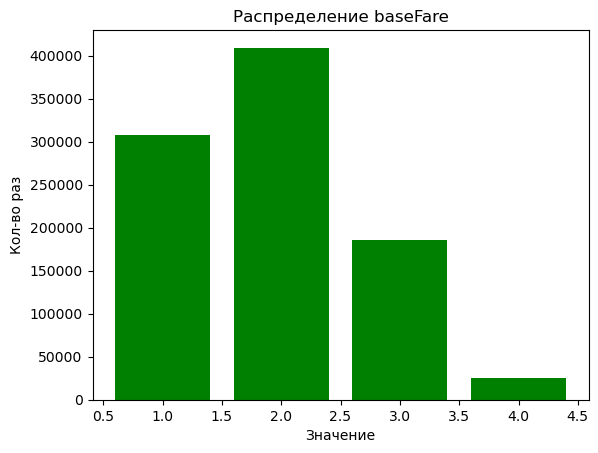

+-------------+------+
|bucketFeature| count|
+-------------+------+
|          1.0|238719|
|          2.0|401001|
|          3.0|231223|
|          4.0| 57676|
+-------------+------+



<BarContainer object of 4 artists>

Text(0.5, 1.0, 'Распределение totalFare')

Text(0.5, 0, 'Значение')

Text(0, 0.5, 'Кол-во раз')

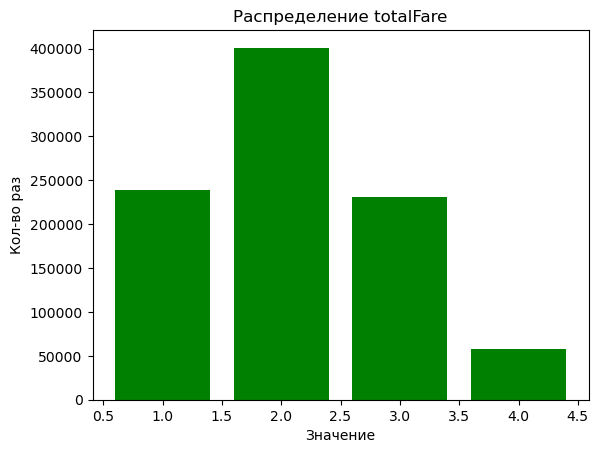

+-------------+------+
|bucketFeature| count|
+-------------+------+
|          1.0| 17235|
|          2.0| 28859|
|          3.0| 57362|
|          4.0|104084|
|          5.0| 97922|
|          6.0| 73526|
|          7.0| 99276|
|          8.0| 56755|
|          9.0| 51829|
|         10.0| 57588|
|         11.0| 35561|
|         12.0| 37017|
|         13.0| 85171|
|         14.0| 61611|
|         15.0| 28919|
|         16.0| 19956|
|         17.0|  7093|
|         18.0|  4629|
|         19.0|  4048|
|         20.0|   178|
+-------------+------+



<BarContainer object of 20 artists>

Text(0.5, 1.0, 'Распределение totalTravelDistance')

Text(0.5, 0, 'Значение')

Text(0, 0.5, 'Кол-во раз')

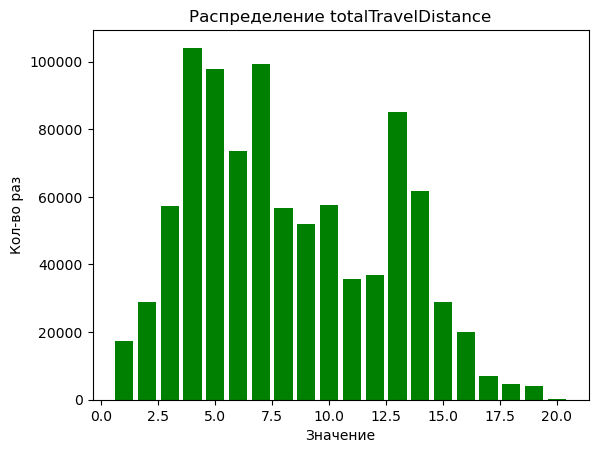

In [26]:
### Построение гистограммы для каждой выбранной колонки
# num_buckets - количество бакетов, на которые разделяется диапазон значений в столбце
# step - шаг разделения для формирования бакета
# splits - границы бакетов - от -бесконечность до +бесконечность и промежуточные значения на основе шага step
num_buckets = 20
step = 4000 / num_buckets
splits = [float("-inf")] + [i * step for i in range(0, num_buckets)] + [float("inf")]
selected_columns = ['baseFare', 'totalFare','totalTravelDistance']

### Построение гистограммы для каждой колонки
# создание объекта Bucketizer (трансформер) с границами splits для разделения на бакеты числовых данных
# transform - применение бакетайзера к данным
# группировка по столбцу bucketFeature и подсчет количества элементов в каждом бакете
for selected_column in selected_columns:
    bucketizer = Bucketizer(splits=splits, inputCol=selected_column, outputCol="bucketFeature")
    df_bucket = bucketizer.transform(cleaned_dataframe)
    bucket_counts = df_bucket.groupBy("bucketFeature").count().orderBy("bucketFeature")
    bucket_counts.show()
    bucket_counts_pd = bucket_counts.toPandas()
    plt.bar(bucket_counts_pd["bucketFeature"], bucket_counts_pd["count"], align="center", width=0.8, color='green', label=selected_column)
    plt.title(f"Распределение {selected_column}")
    plt.xlabel("Значение")
    plt.ylabel("Кол-во раз")
    plt.show()

+-------------+------+
|bucketFeature| count|
+-------------+------+
|          0.0|  3062|
|          1.0|125961|
|          2.0| 86554|
|          3.0| 97219|
|          4.0|129961|
|          5.0|131212|
|          6.0|112443|
|          7.0| 81642|
|          8.0| 60015|
|          9.0| 44489|
|         10.0| 28766|
|         11.0| 18467|
|         12.0|  8828|
+-------------+------+



<BarContainer object of 13 artists>

Text(0.5, 1.0, 'Распределение travelDuration')

Text(0.5, 0, 'Значение')

Text(0, 0.5, 'Кол-во раз')

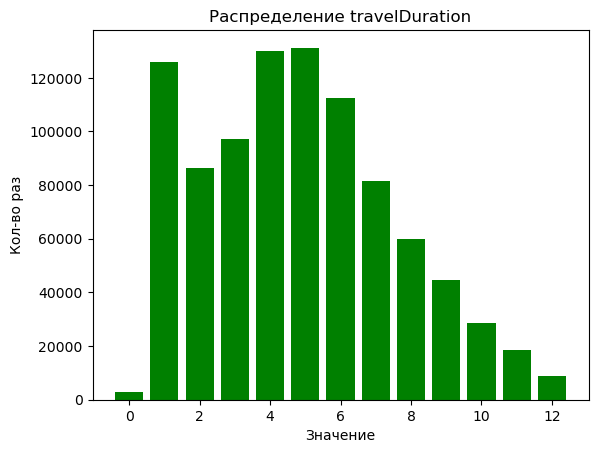

In [27]:
num_buckets = 20
step = 1500 / num_buckets
splits = [float("-inf")] + [i * step for i in range(1, num_buckets)] + [float("inf")]

bucketizer = Bucketizer(splits=splits, inputCol='travelDuration', outputCol="bucketFeature")
df_bucket = bucketizer.transform(cleaned_dataframe)
bucket_counts = df_bucket.groupBy("bucketFeature").count().orderBy("bucketFeature")
bucket_counts.show()
bucket_counts_pd = bucket_counts.toPandas()
plt.bar(bucket_counts_pd["bucketFeature"], bucket_counts_pd["count"], align="center", color='green', label='travelDuration')
plt.title(f"Распределение {'travelDuration'}")
plt.xlabel("Значение")
plt.ylabel("Кол-во раз")
plt.show()

<BarContainer object of 16 artists>

Text(0.5, 1.0, 'Распределение startingAirport')

Text(0.5, 0, 'startingAirport')

Text(0, 0.5, 'Кол-во раз')

<BarContainer object of 16 artists>

Text(0.5, 1.0, 'Распределение destinationAirport')

Text(0.5, 0, 'destinationAirport')

Text(0, 0.5, 'Кол-во раз')

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Распределение isNonStop')

Text(0.5, 0, 'isNonStop')

Text(0, 0.5, 'Кол-во раз')

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Распределение isBasicEconomy')

Text(0.5, 0, 'isBasicEconomy')

Text(0, 0.5, 'Кол-во раз')

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Распределение isRefundable')

Text(0.5, 0, 'isRefundable')

Text(0, 0.5, 'Кол-во раз')

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Распределение seatsRemaining')

Text(0.5, 0, 'seatsRemaining')

Text(0, 0.5, 'Кол-во раз')

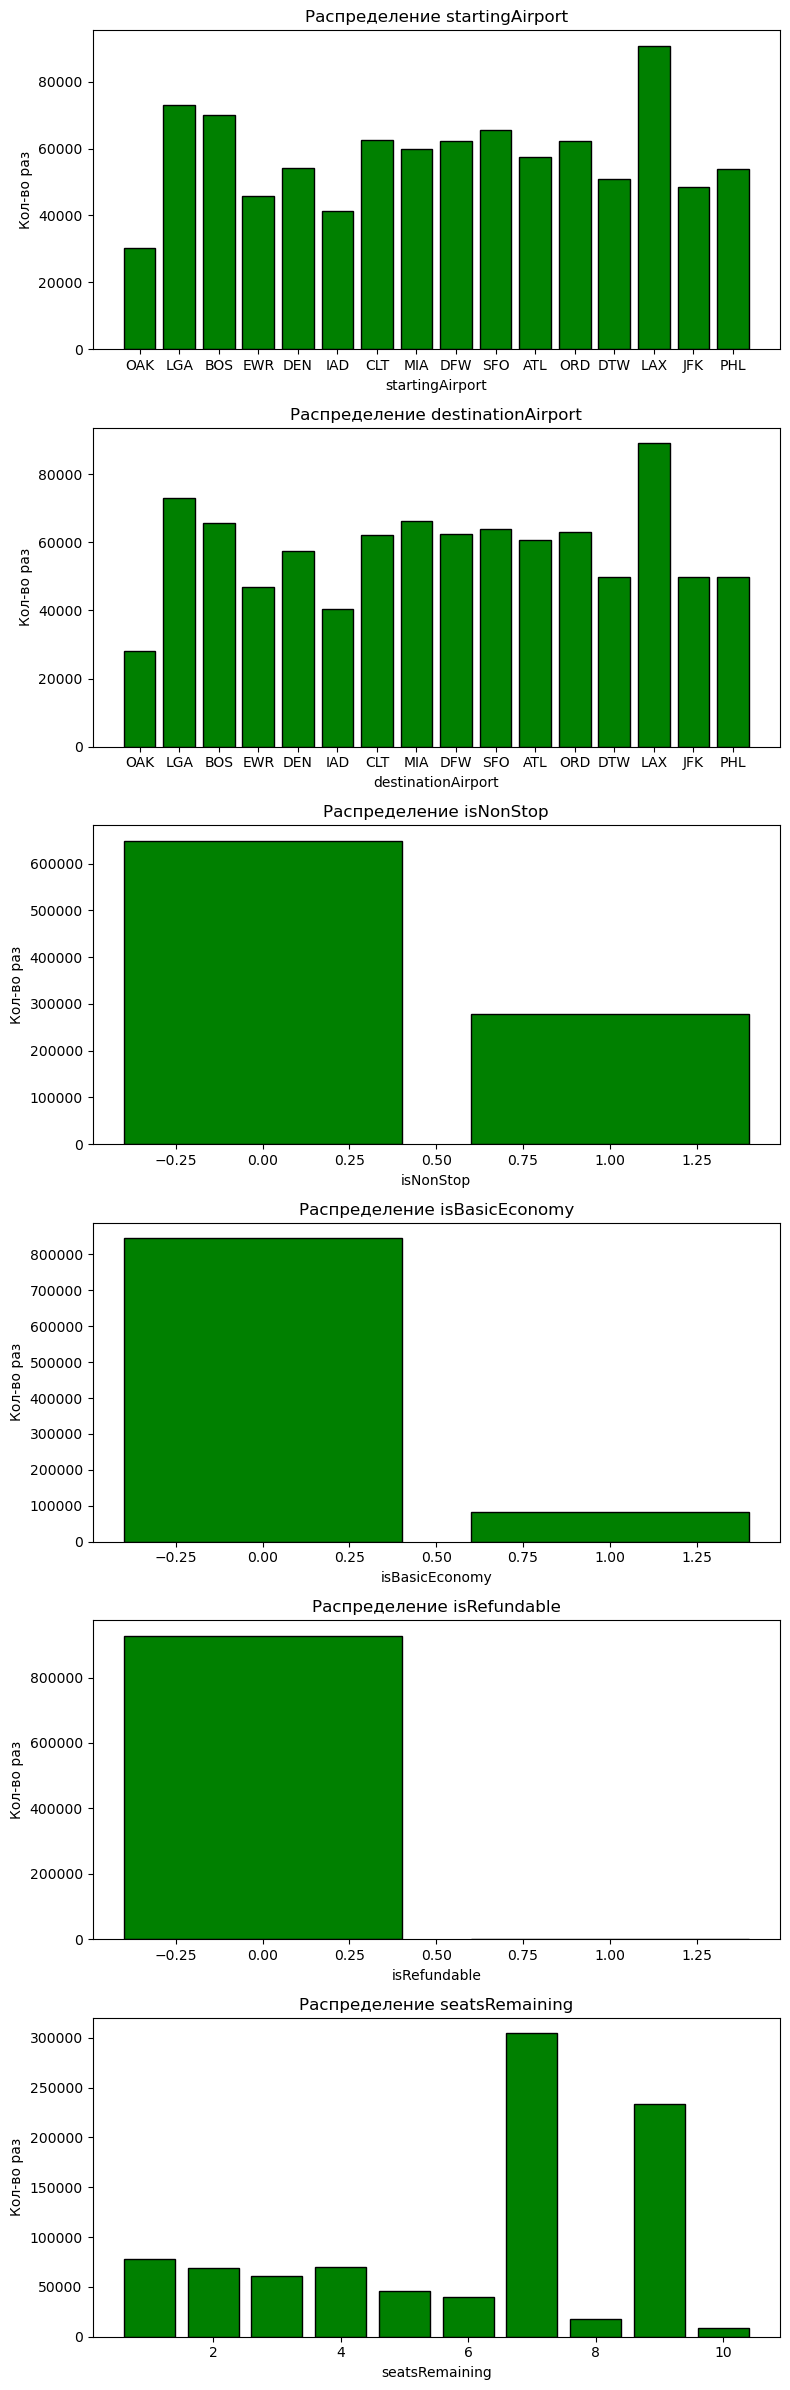

In [28]:
selected_features = ['startingAirport', 'destinationAirport', 'isNonStop',
                    'isBasicEconomy', 'isRefundable', 
                    'seatsRemaining'] 

fig, axs = plt.subplots(len(selected_features), 1, figsize=(8, 4 * len(selected_features)))

# Построение гистограмм для каждого выбранного признака
for i, feature in enumerate(selected_features):
    # Сгруппировать по признаку и подсчитать количество
    data_grouped = cleaned_dataframe.groupBy(feature).count().collect()
    # Извлечение данных для построения графика
    categories = [row[0] for row in data_grouped]
    counts = [row[1] for row in data_grouped]
    axs[i].bar(categories, counts, color='green', edgecolor='black')
    axs[i].set_title(f'Распределение {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Кол-во раз')

# Регулировка расположения подграфиков
plt.tight_layout()

# Отображение графика
plt.show()

In [29]:
# Создаем VectorAssembler для объединения признаков в один вектор
# vector_assembler - трансформатор, объединяющий столбцы feature_cols в вектор-столбец
feature_cols = ['baseFare', 'totalFare','totalTravelDistance', 'travelDuration']  
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Применяем VectorAssembler к данным
data = vector_assembler.transform(cleaned_dataframe)

# Вычисляем матрицу корреляции
correlation_matrix = Correlation.corr(data, "features").head()
correlation_array = correlation_matrix[0].toArray()

# Выводим матрицу корреляции
correlation_df = pd.DataFrame(correlation_array, columns=feature_cols)

In [30]:
# Вычисление корреляционной матрицы
correlation_df.corr()

,baseFare,totalFare,totalTravelDistance,travelDuration
baseFare,1.000000,0.999754,-0.781313,-0.886215
totalFare,0.999754,1.000000,-0.794933,-0.875713
totalTravelDistance,-0.781313,-0.794933,1.000000,0.404598
travelDuration,-0.886215,-0.875713,0.404598,1.000000


<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Матрица корреляции признаков')

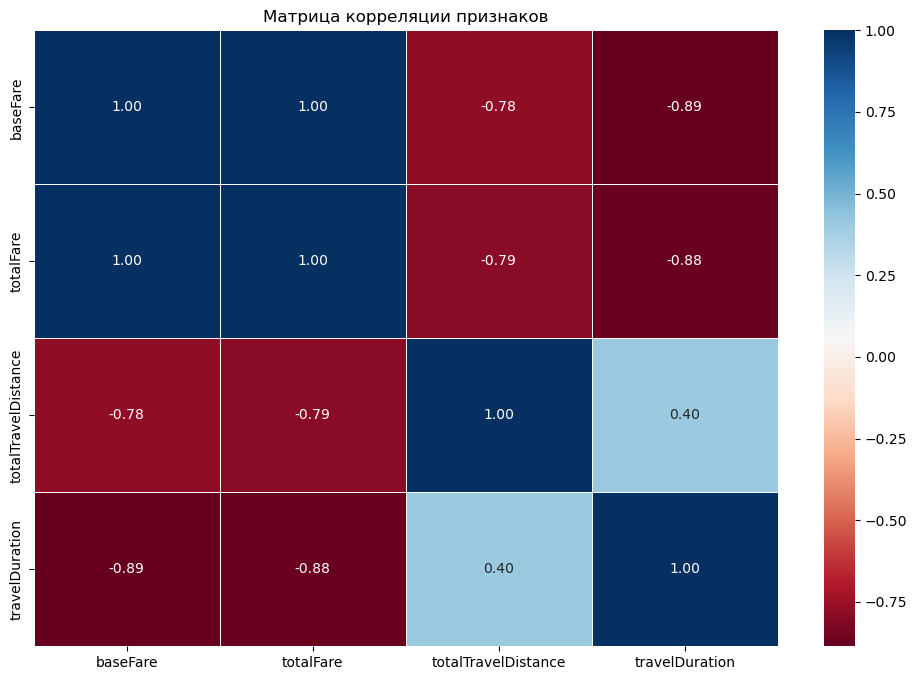

In [35]:
# Тепловая карта корреляции с использованием Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df.corr(), annot=True, cmap="RdBu", fmt=".2f", linewidths=.5)
plt.title('Матрица корреляции признаков')
plt.show()

In [20]:
cleaned_dataframe.coalesce(1).write.options(header='True', delimiter=';').csv('new_csv')